# Galaxy fitting with KinMS_fitter

This tutorial aims at getting you up and running with simple galaxy kinematic modelling using KinMS! 

To start you will need to install KinMS, and the KinMS_fitter routines. These can be installed together using `pip install kinms-fitter`.

To get started with kinematic modelling we will complete the following steps:
1. Generate a model to fit (can be skipped if you have your own observed data cube)
2. Read that cube in with KinMS_fitter, and provide some initial guesses for parameters.
3. Get fitting!



## Generate a model

Here we will use one of the KinMS test suite routines to generate a simple mock datacube that we can use to test our fitting. 


The `expdisk` function from the test suite creates a disc with an exponential surface brightness profile, and  a rotation curve that has a linear rise in the centre, and then is flat. This disc is observed with a 4$^{\prime\prime}$ beam, and has an extent and inclination that can be set by the user. See the other KinMS tutorials, and the test suite itself for full details.

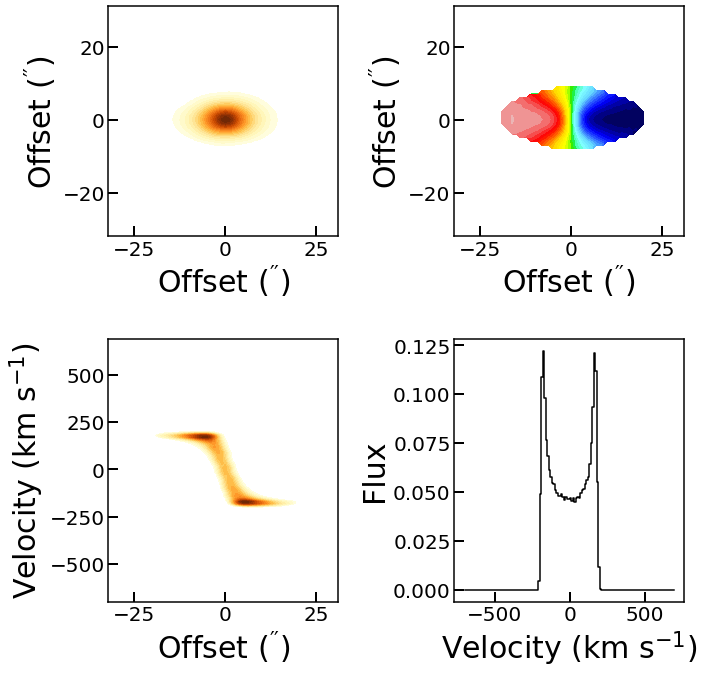

In [1]:
from kinms.examples.KinMS_testsuite import expdisk

data=expdisk(fileName='Output',scalerad=5, inc=60)

This has now created the mock datacube, named 'Output_simcube.fits' in our directory, so we can proceed with `KinMS_fitter`.

## Fitting with KinMS_fitter

### Philosophy of KinMS_fitter

KinMS_fitter has been designed to be as simple as possible. If run with all parameters at their defaults it will:

* Assume the gas surface brightness profile has an exponential form
* Assume you want to fit the velocity curve freely in individual beam-sized apertures (tilted-ring style)
* Fit the free parameters of the above, along with the geometric paramters of the disc (PA, inclination), and the typical nuisance paramters (kinematic centre in RA, Dec, Vsys; and the total flux of the system)

By using other parameters one can in a simple way:

* Use parameterized rotation curves (e.g. arctan models, Kelpalrians, disc/bulge, etc) or rotation curves from MGE models, AND combinations of these.
* Use more complex surface brightness parameterisations (rings, holes, etc)  AND combinations of these.

First here will we demonstrate the simple case.


We begin by importing KinMS_fitter:

In [2]:
from kinms_fitter import kinms_fitter

Now we can load in the datacube.

In [3]:
fit=kinms_fitter('Output_simcube.fits')

As our datacube is a bit bigger than our actual source, for speed we may want to cut down the cube. Ideal sizes are $2^N$, but you can experiment with your own sources. KinMS_fitter will tell you how long a single model takes to generate, so you can optimise this. 

`spatial_trim` cuts your cube in the spatial directions, and needs to be a 4 element vector of the form [start_x, end_x, start_y, end_y]

`spectral_trim` shows what channels to include. Here our signal is between channel ~47 and 93. We want to ensure we have some line-free channels on either end, but not too many.

`linefree_chans` allows you to tell the code where to estimate the RMS - it defaults to channels 1 -> 6.

Given the above, the line below will be a better choice for our datacube than leaving everything at its defaults.

In [4]:
fit=kinms_fitter('Output_simcube.fits',spatial_trim=[16,48,16,48],spectral_trim=[43,98],linefree_chans=[30,45])

Now we can provide initial guesses for parameters, if we wish. The code attempts to set sensible defaults, but these are not perfect. Below we set guesses for the position angle only (see later for a full list of possibilities).

In [5]:
fit.pa_guess=90

Given we are using the simple "tilted-ring" type model for velocities, its also crucial to set the hyperparameter `nrings`. This is the number of beam size elements you have across your galaxy. Set this too large and it will do crazy things in the outer parts where it isnt constrained!

In [6]:
fit.nrings=5

One last thing - because we are fitting to noiseless model data here, the RMS estimated from the cube in the standard way is zero! (You can see this by printing `fit.rms`). In this case we will set a mock RMS. Doing this could also sensible if you want to override the autoestimate of the code for other reasons.

In [7]:
fit.rms=1e-3 # Jy/beam

Now we are ready to run a simple fit! We start with a simple least-square minimisation routine that relatively quickly can hopefully find a good fit. We can then use this best fit as an input to an MCMC approach which can give us good error estimates. 

The code will show the initial guess model over the input data, (optionally) output a variety of fitting messages, and then finally plot the newly optimised model over the data. The time taken will vary depending how close to optimal your initial guesses are. This simple fit starting from a very non-optimal model took ~10 minutes on my desktop machine.

==============   Welcome to KinMS_fitter!   ==============

        ██╗  ██╗██╗███╗   ██╗███╗   ███╗███████╗
        ██║ ██╔╝██║████╗  ██║████╗ ████║██╔════╝
        █████╔╝ ██║██╔██╗ ██║██╔████╔██║███████╗
        ██╔═██╗ ██║██║╚██╗██║██║╚██╔╝██║╚════██║
        ██║  ██╗██║██║ ╚████║██║ ╚═╝ ██║███████║
        ╚═╝  ╚═╝╚═╝╚═╝  ╚═══╝╚═╝     ╚═╝╚══════╝
        
One model evaulation takes 0.31 seconds


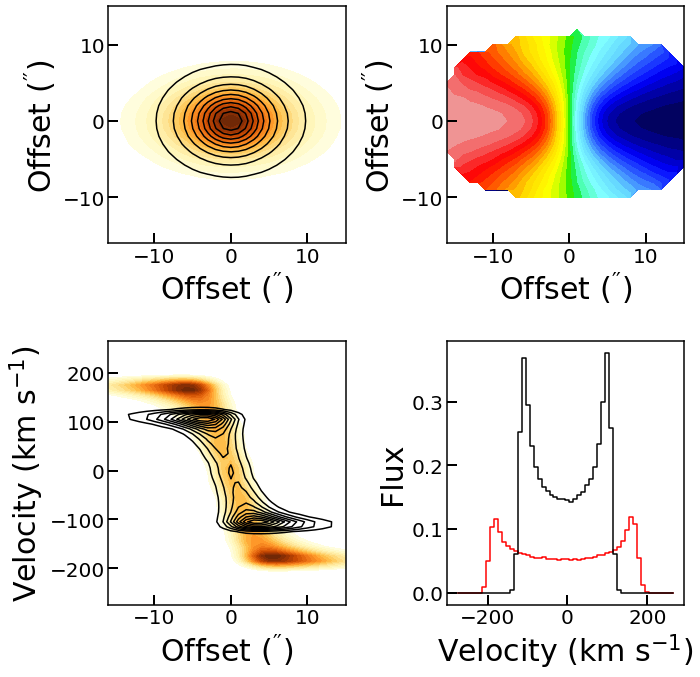

============== Begin simple fitting process ==============
Steps: 0 chi2: 6948.929095875356
Steps: 50 chi2: 6943.07855077689
Steps: 100 chi2: 6226.282280465042
Steps: 150 chi2: 702.9087630975627
Steps: 200 chi2: 664.9989562285384
Steps: 250 chi2: 609.7719701938902
Steps: 300 chi2: 1988.9600314854724
Steps: 350 chi2: 379.87501125056514
Steps: 400 chi2: 363.18896892787825
Steps: 450 chi2: 321.3001543700856
Steps: 500 chi2: 180.17541887841094
Steps: 550 chi2: 167.01809463722046
Steps: 600 chi2: 109.70953483883757
Steps: 650 chi2: 102.21305970194578
Steps: 700 chi2: 83.50921250099776
Steps: 750 chi2: 52.690162323215525
Steps: 800 chi2: 34.12043164734471
Steps: 850 chi2: 26.323000300308887
Steps: 900 chi2: 24.967333512120835
Steps: 950 chi2: 22.733689754282377
Steps: 1000 chi2: 22.149227047960263
Steps: 1050 chi2: 21.72460405100775
Steps: 1100 chi2: 21.03103123146295
Steps: 1150 chi2: 36.284524938287745
Steps: 1200 chi2: 18.740587463972584
Steps: 1250 chi2: 18.716443004142608
Steps: 1300 ch

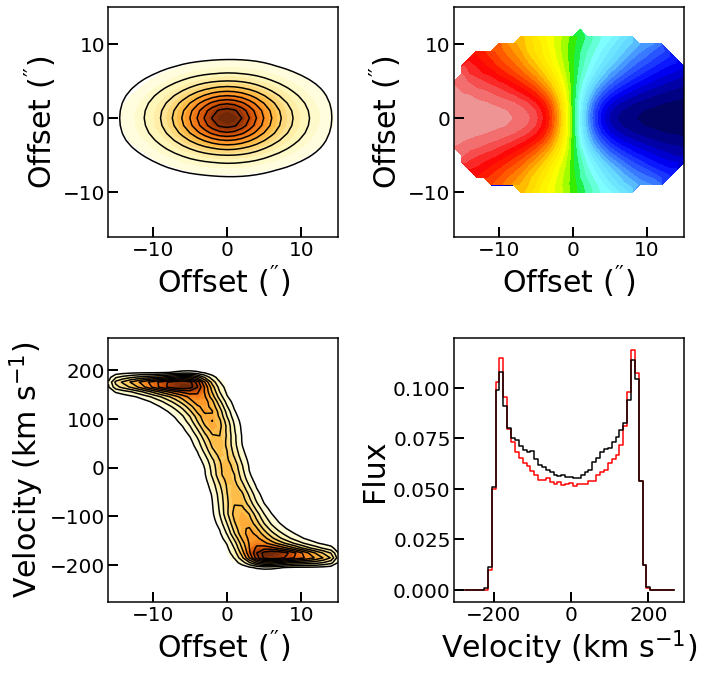

In [8]:
bestvals, besterrs, acceptedsteps, acceptedsteps_ll, parsfixed=fit.run(method='simple')

In [9]:
from astropy.table import Table
truths=[90,12,10,0,60,25,10,5,  100., 210., 210., 210., 210.] # the true values we would hope to retrieve
print(Table([fit.labels,bestvals,truths],names=('Quantity', 'Bestfit', 'True value')))

 Quantity       Bestfit       True value
---------- ------------------ ----------
        PA  90.01237420627412       90.0
        Xc 12.000137853010196       12.0
        Yc  9.999860031433988       10.0
      Vsys -4.960503288263726        0.0
       inc    60.711373033455       60.0
   totflux 27.681894932500697       25.0
   veldisp  9.407731177376979       10.0
Rscale_exp  5.187006827714002        5.0
        V0  82.79525147328644      100.0
        V1  215.5708410276646      210.0
        V2 205.57367082867572      210.0
        V3 210.58798214709986      210.0
        V4 208.88161815570297      210.0


As you can see we get a very nice fit, with the parameters all pretty much correct.  

Now one can go ahead and run a longer chain, and plot the corner plots to visualize covariances etc. With `method='mcmc'` you want to run for a good number of steps - e.g. `fit.niters=10000` or `30000`, to get good estimates of the errors and visualise the covariances. This is relatively slow - but the code is parallelised, so will more quickly on a larger machine. You can control the number of threads the code uses by setting `fit.nprocesses` to a positive integer. 

Once the run has finished (this takes an hour and a half on my machine - if you need results faster try running on a large machine with many cores) you can plot the corner plot to see the covariances etc by setting `fit.show_corner=True`. If you'd like to save these plots then set `fit.pdf=True`.

==============   Welcome to KinMS_fitter!   ==============

        ██╗  ██╗██╗███╗   ██╗███╗   ███╗███████╗
        ██║ ██╔╝██║████╗  ██║████╗ ████║██╔════╝
        █████╔╝ ██║██╔██╗ ██║██╔████╔██║███████╗
        ██╔═██╗ ██║██║╚██╗██║██║╚██╔╝██║╚════██║
        ██║  ██╗██║██║ ╚████║██║ ╚═╝ ██║███████║
        ╚═╝  ╚═╝╚═╝╚═╝  ╚═══╝╚═╝     ╚═╝╚══════╝
        
One model evaulation takes 0.31 seconds


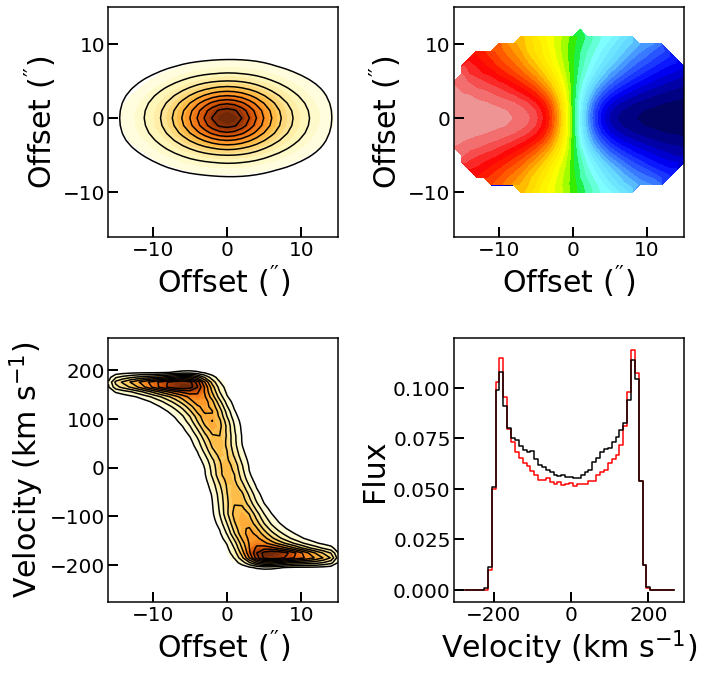

==============  Begin MCMC fitting process  ==============
Parameters Fixed: []
Correction for chi-sqr variance applied: 11.362761731754972
Doing chain 1
     Chain has not converged - Accept rate: 0.06923076923076923
Chain converged: LL: -15.37174904299579 - Accept rate:0.26153846153846155
Best chain so far!
Best fit:
  PA: 89.53562919295821
  Xc: -0.011442252240101425
  Yc: 0.06297641787953846
  Vsys: -4.960503288263726
  inc: 61.2229773599575
  totflux: 27.681894932500697
  veldisp: 9.622336275994877
  Rscale_exp: 5.2647239272647175
  V0: 97.98462200444388
  V1: 214.04432570289043
  V2: 205.57367082867572
  V3: 209.75508920178603
  V4: 207.9776019387112
Starting final chain


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 62.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 62.7min finished


Final best fit values and 1sigma errors:
  PA: 90.00710914251361 ± 0.3930965201271519
  Xc: -0.0012182934750327168 ± 0.06567756306518995
  Yc: -0.0013043979233451873 + 0.04859920711578053 - 0.058235349672109846
  Vsys: -5.011619269098278 ± 0.5238056175162327
  inc: 60.037352431360745 + 0.8035003581751496 - 0.6775327800855067
  totflux: 27.687362604930986 ± 0.5137290290714134
  veldisp: 9.502785641911597 ± 0.6073385717634903
  Rscale_exp: 5.094728004586421 + 0.14775003495521144 - 0.1201844903815088
  V0: 85.78122836692202 ± 10.023170942898588
  V1: 216.80455265008686 ± 2.9706164979831726
  V2: 207.03751041362418 + 1.8390684030113107 - 2.0578984114781065
  V3: 211.75149883997145 + 3.7164677151708077 - 3.1974801661211814
  V4: 208.61769198442698 ± 4.210670296697074
MCMC fitting process took 4149.07 seconds


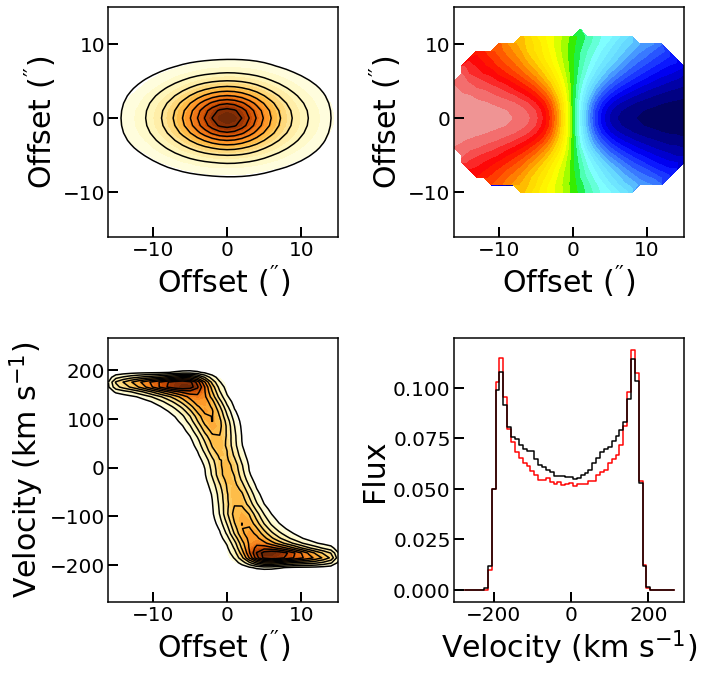

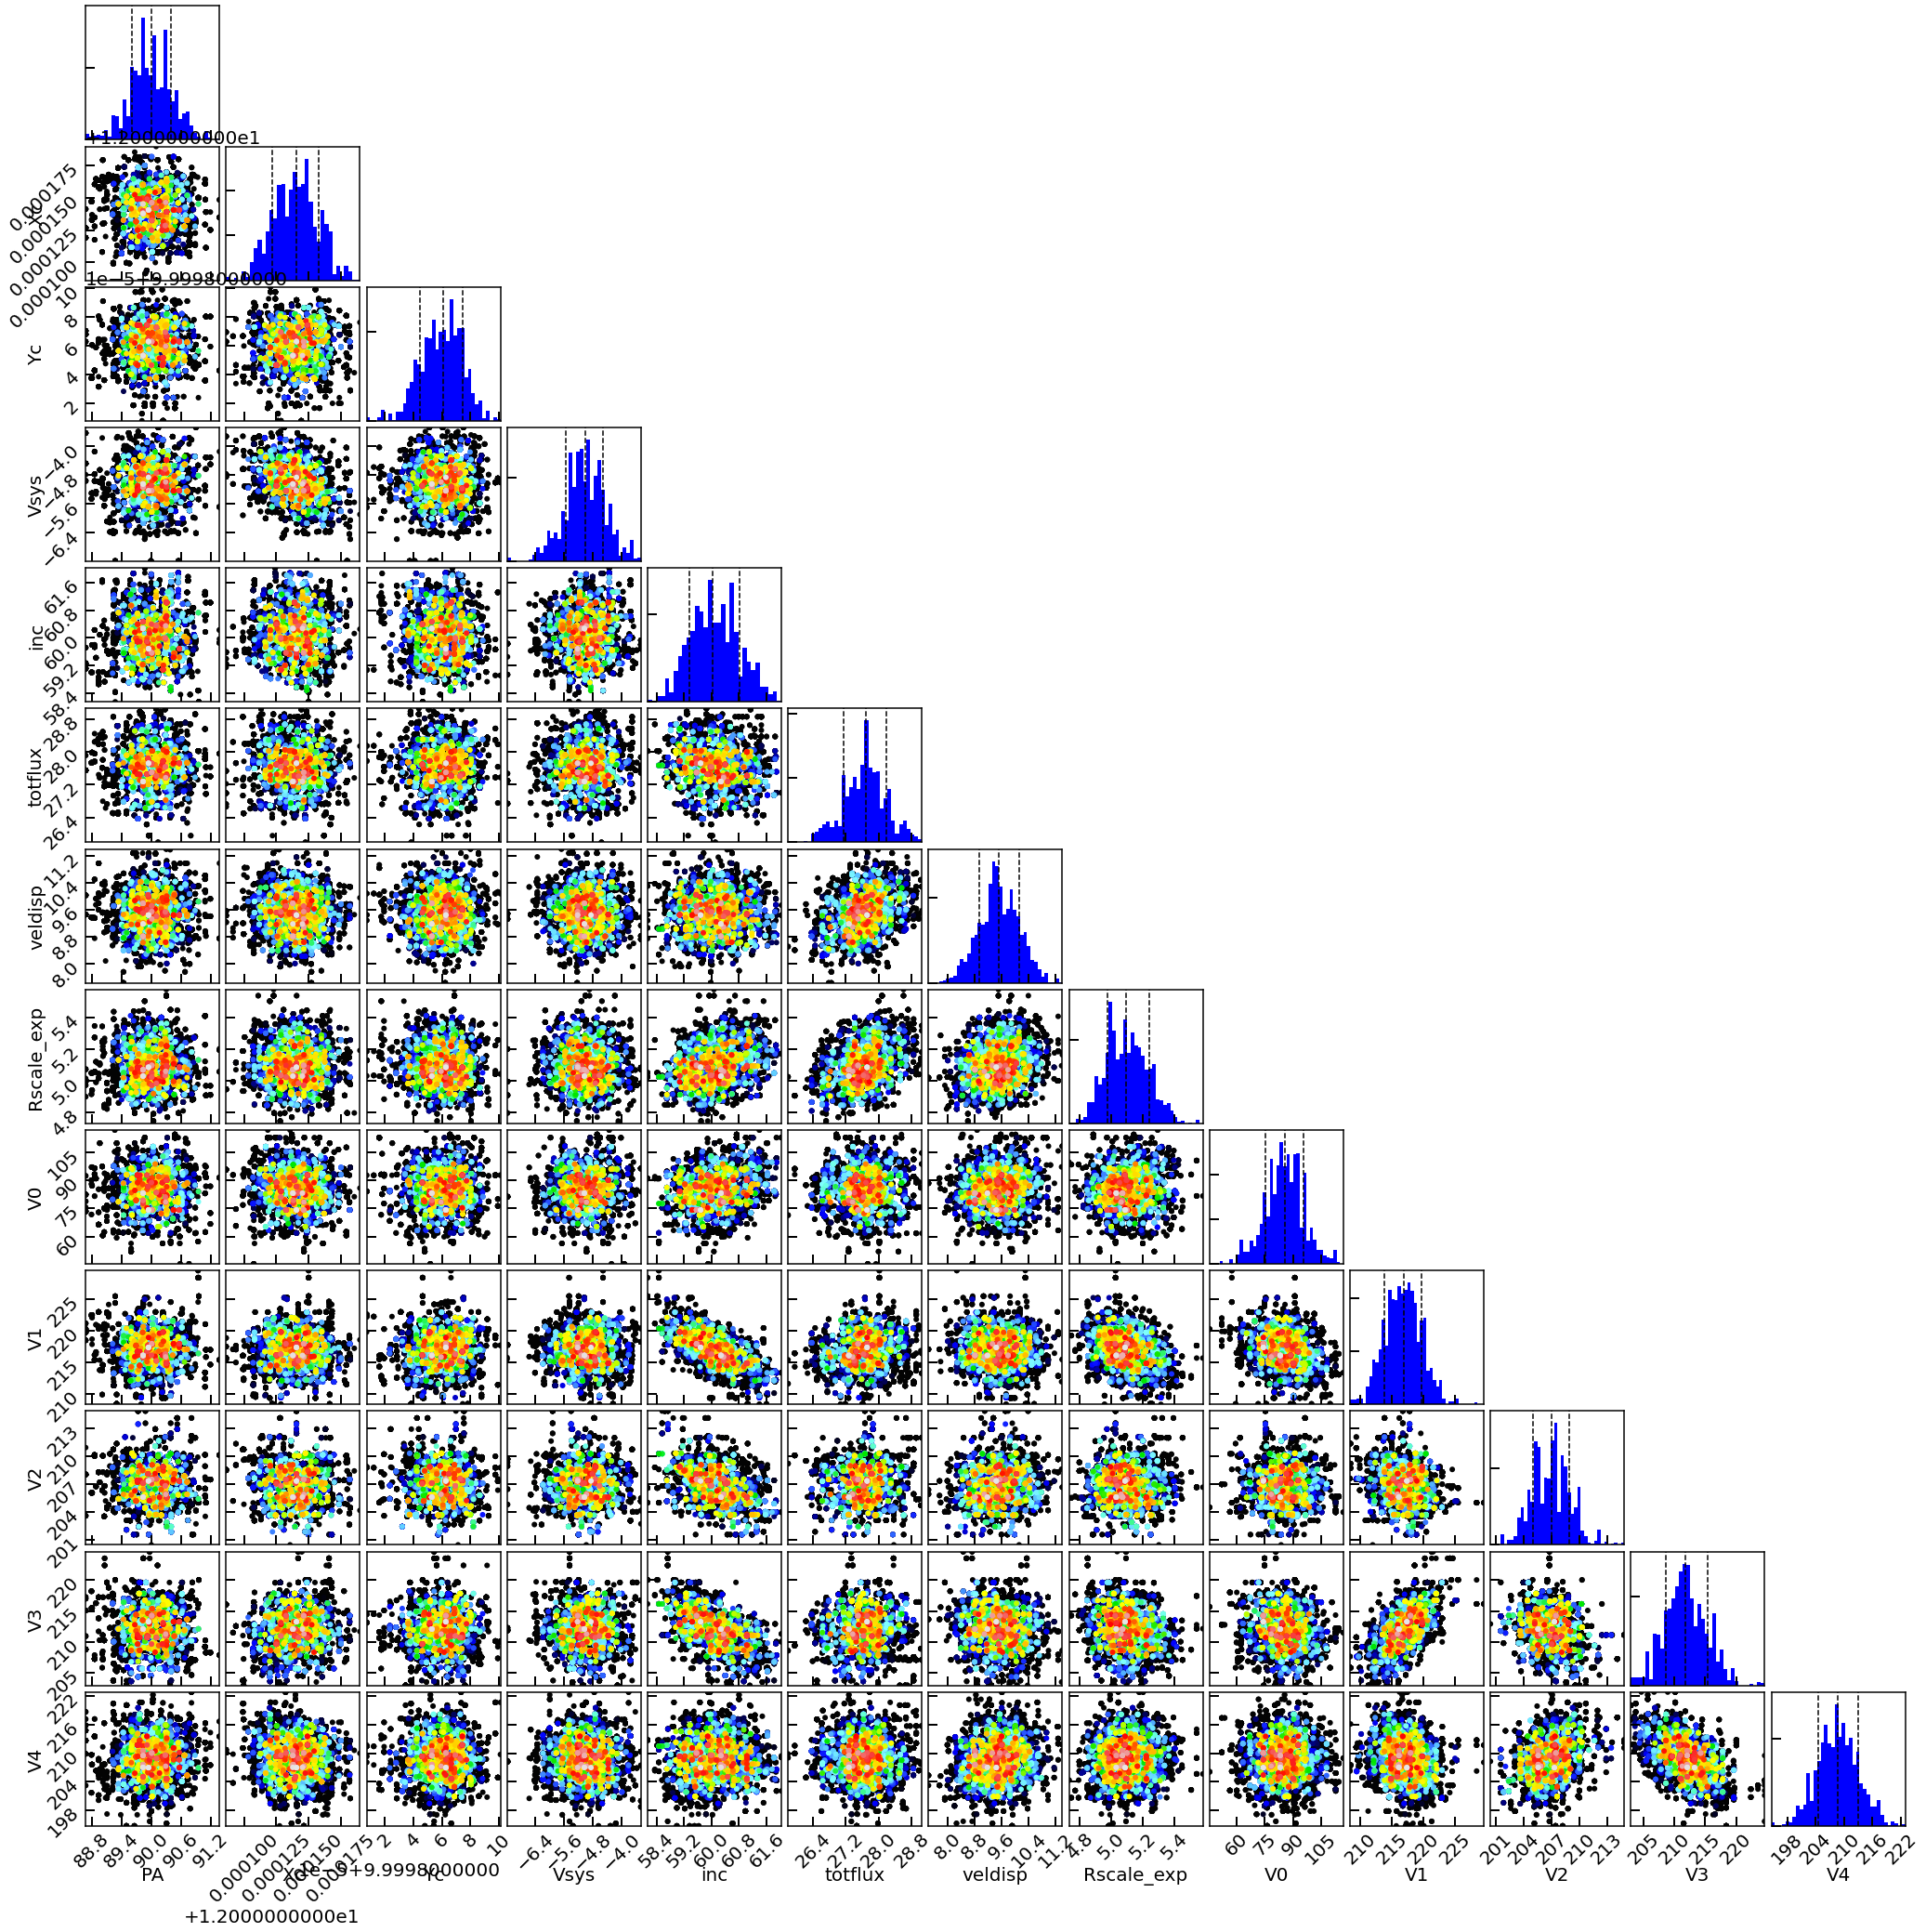

In [10]:
fit.niters=30000
fit.initial_guesses=bestvals # start from our previous best fit
fit.show_corner=True # show the corner plots
bestvals, besterrs, acceptedsteps, acceptedsteps_ll, parsfixed =fit.run(method='mcmc')   

## Using more complex velocity and surface brightness profile shapes

Often an exponential disc/tilted ring type velocity structure does not capture the physics you want to include in your modelling. In these cases KinMS_fitter has a simple way to help - via the `sb_profs` and `velocity_profs` modules.

In [16]:
from kinms_fitter.sb_profs import sb_profs
from kinms_fitter.velocity_profs import velocity_profs  

Examples of current functionality of these are shown below - adding new features is easy however, so get in contact if your favourite form is not avaliable!

### Surface brightness profiles

First, lets reproduce a basic exponential disc, as used by default in KinMS_fitter. You can call the `sb_profs.expdisk` profile, and supply guesses, and limits, for its two free parameters (the central brightness ($I_0$), and the scale radius ($r_{scale}$) as below. 


$
\begin{align}
\large I_{gas}(r) = I_0 e^{\frac{-r}{r_{scale}}}
\end{align}
$

If you are only passing a single function to KinMS_fitter then you should fix the flux normalisation, as that will be handled seperately by fitting the total flux of the model. You can do this by passing just the scale length parameter. If you supply multiple components then you should fix one, and fit the other fluxes relative to that. 

In [17]:
guesses=[10]
mymodel=[sb_profs.expdisk(guesses=guesses,minimums=[0],maximums=[20],fixed=[False])]

To demonstrate this profile, we can define a radius array, and plot the SB profile resulting:

Text(0, 0.5, 'Brightness')

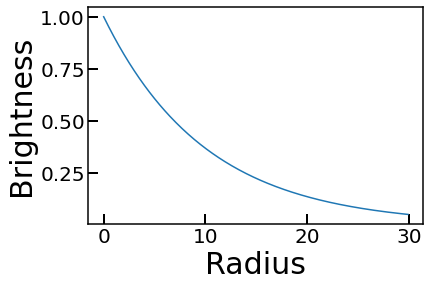

In [18]:
import matplotlib.pyplot as plt
import numpy as np
r=np.arange(0,30,0.1)
plt.plot(r,sb_profs.eval(mymodel,r,guesses)) 
plt.xlabel("Radius")
plt.ylabel("Brightness")

As you may have noted above, mymodel is actually a list. As such we can combine many surface profiles together by adding them to the list! Below we add a second, more concentrated exponential disc. Note we only fix one of the fluxes!

In [21]:
mymodel=[sb_profs.expdisk(guesses=[10],minimums=[0],maximums=[20]),\
         sb_profs.expdisk(guesses=[1,3],minimums=[0,0],maximums=[100,20],fixed=[False,False])]

Lets see what that looks like... (total result in blue, the two components are plotted as orange and green lines).

Text(0, 0.5, 'Brightness')

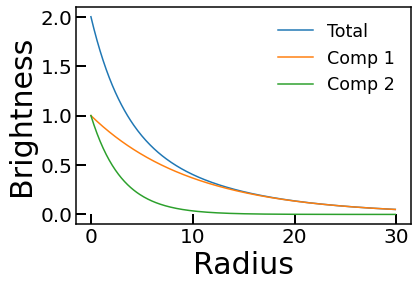

In [23]:
guesses=np.concatenate([i.guess for i in mymodel]) # this line just sets the parameters to the guesses inputed above
plt.plot(r,sb_profs.eval(mymodel,r,guesses),label='Total')
plt.plot(r,sb_profs.eval([mymodel[0]],r,guesses[0:1]),label='Comp 1')
plt.plot(r,sb_profs.eval([mymodel[1]],r,guesses[1:]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Brightness")

Instead of an exponential, maybe we add in a gaussian ring! Here the free parameters are the gaussians peak, its central radius, and width. Note that the defaults assume none of the parameters are fixed, so you can leaved `fixed=...` out if you wish.

In [24]:
mymodel=[sb_profs.expdisk(guesses=[10],minimums=[0],maximums=[20]),\
         sb_profs.gaussian(guesses=[2,10,1],minimums=[0,0,0],maximums=[10,100,20])]

Text(0, 0.5, 'Brightness')

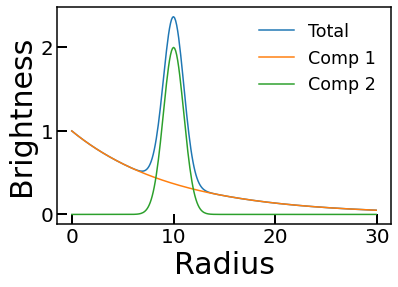

In [25]:
guesses=np.concatenate([i.guess for i in mymodel]) # this line just sets the parameters to the guesses inputed above
plt.plot(r,sb_profs.eval(mymodel,r,guesses),label='Total')
plt.plot(r,sb_profs.eval([mymodel[0]],r,guesses[0:1]),label='Comp 1')
plt.plot(r,sb_profs.eval([mymodel[1]],r,guesses[1:]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Brightness")

Finally, you can add multiplicative components to the model, like a cutoff, to here to simulate a hole in the centre of a galaxy. The free parameters are radius of the start and end of the cutoff.

Text(0, 0.5, 'Brightness')

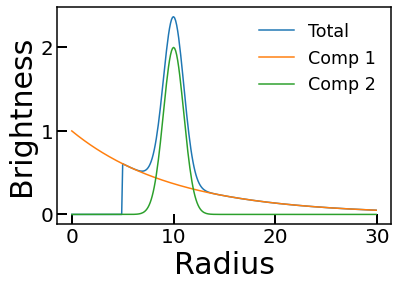

In [26]:
mymodel=[sb_profs.expdisk(guesses=[10],minimums=[0],maximums=[20]),\
         sb_profs.gaussian(guesses=[2,10,1],minimums=[0,0,0],maximums=[10,100,20]),\
         sb_profs.cutoff(guesses=[0,5],minimums=[0,1],maximums=[10,20])]

guesses=np.concatenate([i.guess for i in mymodel]) # this line just sets the parameters to the guesses inputed above
plt.plot(r,sb_profs.eval(mymodel,r,guesses),label='Total')
plt.plot(r,sb_profs.eval([mymodel[0]],r,guesses[0:1]),label='Comp 1')
plt.plot(r,sb_profs.eval([mymodel[1]],r,guesses[1:4]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Brightness")

Note: you cant plot component 3 alone, as it is a multiplicative component, but its effect is clear in the blue "total" line.

In this way you can add surface brightness components together, and fit their free parameters with KinMS_fitter.

<b>Warning: pay careful attention to areas where you could create parameter degeneracies. For instance multiple flux components, or when you have two similar profiles (e.g. our double exponential, above) that could swap positions. You should fix parameters, or constain the minimums/maximums where needed to avoid this!</b>

### Velocity profiles

Adding different velocity profiles works similarly to adding surface brightness components, but using `kinms_fitter.velocity_profs`. At the moment four different types of velocity profiles exist in the module, but more will be added as time goes on. These are:

* A tilted ring (i.e. piecewise linear) velocity curve with an arbitary number of free parameters. This has one set of  hyperparameters - the radii of the rings to fit. Guesses (and limits) required for the velocity of each ring in km/s.<p>

* An arctan function $V(r)=\frac{2V_{max}}{\pi}arctan\frac{R}{R_{turn}}$. This profile has no hyperparameters, and requires guesses (and limits) for $V_{max}$ in km/s and $R_{turn}$ in arcseconds.<p>

* A Keplarian $V(r)=\sqrt{\frac{GM}{R}}$. This profile has the distance to the galaxy as a hyperparameter (to convert the radius in arcseconds to parsecs), and requires a single input guess (with limits) for M, in units of $\log_{10}$ solar masses. <p>
    
* An MGE potential (see https://www-astro.physics.ox.ac.uk/~mxc/software/#mge). Input hyperparameters are the MGE surface brightness, radius and axial ratio (q). Either one or two fitted parameters can either be supplied -  the M/L in the band the MGE was created in (in Msun/Lsun units), and (optionally) the black hole mass. The inclination of the stellar body of the galaxy is assumed to be the same as that of the gas disc.<p>
    
* An NFW dark matter halo. The only required input hyperparameter is the distance to the object in question, while the Hubble Parameter can also be specified (default=67 km/s/Mpc). Two parameters are fitted: The log of the halo mass (M$_200$) and the concentration.  <p>
    
* A sersic density profile, which is assumed to be round. The only input hyperparameter is the distance to the object in question, and the fitted parameters are the log of the stellar mass of that component, its effective radius, and its sersic index. <p>
    
When multiple velocity profiles are included in your model, the final result will have the profiles added in quadarature. Some examples are shown below:
    
Firstly, we can duplicate the tilted ring type approach set as the default:

In [27]:
bincentroids=np.arange(0,30,5) # radii of the bin centroids
mymodel = [velocity_profs.tilted_rings(bincentroids,guesses=[0,250,260,260,250,230],minimums=np.zeros(bincentroids.size),maximums=np.ones(bincentroids.size)*500.)]

And we can plot this, as before.

Text(0, 0.5, 'Velocity (km/s)')

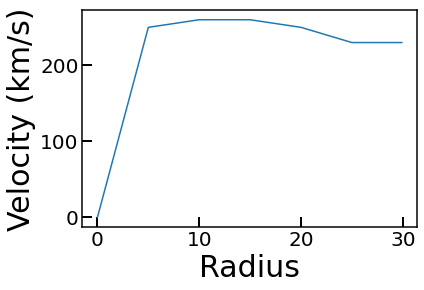

In [28]:
params=np.concatenate([i.guess for i in mymodel])
plt.plot(r,velocity_profs.eval(mymodel,r,params)) 
plt.xlabel("Radius")
plt.ylabel("Velocity (km/s)")

Now one could imagine adding a central point mass (e.g. a SMBH):

In [29]:
mymodel=[velocity_profs.tilted_rings(bincentroids,guesses=[0,250,260,260,250,230],minimums=np.zeros(bincentroids.size),maximums=np.zeros(bincentroids.size)),\
         velocity_profs.keplarian(distance=16.5,guesses=[8],minimums=[5],maximums=[10])]

Plotting this results in the following:

Text(0, 0.5, 'Velocity (km/s)')

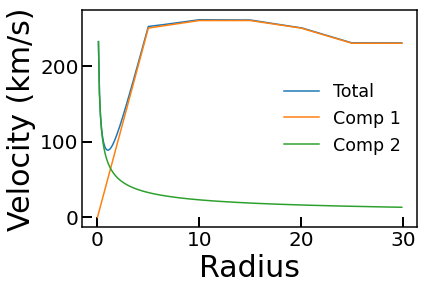

In [30]:
params=np.concatenate([i.guess for i in mymodel])
plt.plot(r,velocity_profs.eval(mymodel,r,params),label="Total")
plt.plot(r,velocity_profs.eval([mymodel[0]],r,params[0:-1]),label='Comp 1')
plt.plot(r,velocity_profs.eval([mymodel[1]],r,params[-1:]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Velocity (km/s)")

One could replace the tilted rings with an arctangent as so:

Text(0, 0.5, 'Velocity (km/s)')

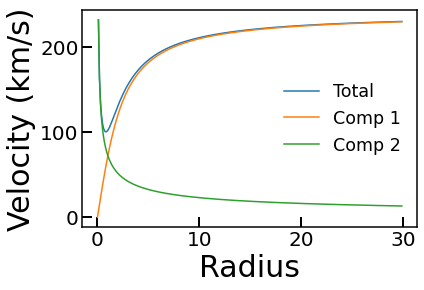

In [31]:
mymodel=[velocity_profs.arctan(guesses=[240,2],minimums=[0,0],maximums=[500,20]),\
         velocity_profs.keplarian(distance=16.5,guesses=[8],minimums=[5],maximums=[10])]

params=np.concatenate([i.guess for i in mymodel])
plt.plot(r,velocity_profs.eval(mymodel,r,params),label="Total")
plt.plot(r,velocity_profs.eval([mymodel[0]],r,params[0:-1]),label='Comp 1')
plt.plot(r,velocity_profs.eval([mymodel[1]],r,params[-1:]),label='Comp 2')
plt.legend(frameon=False)
plt.xlabel("Radius")
plt.ylabel("Velocity (km/s)")

Or finally (for now) by using an MGE model of the stellar potential:

Text(0, 0.5, 'Velocity (km/s)')

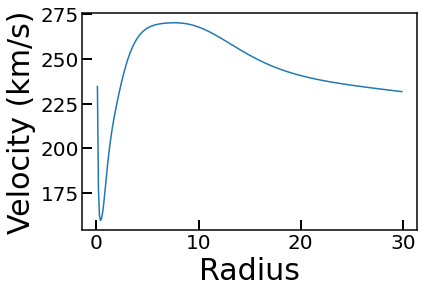

In [32]:
surf=np.array([25551.5, 21118.8, 7436.97, 12016.7, 5862.67, 741.344, 807.669, 212.118])
sigma=np.array([0.226508, 0.661430, 1.30613, 2.17346, 4.76300, 11.3177, 19.2433, 48.5786])
qobs=np.array([0.514866, 0.607566, 0.887495, 0.576108, 0.837162, 0.440516, 0.779643, 0.821153])

mymodel=[velocity_profs.mge_vcirc(surf,sigma,qobs,16.5,guesses=[2,8],minimums=[0.1,7],maximums=[10,10])]

params=np.concatenate([i.guess for i in mymodel])
plt.plot(r,velocity_profs.eval(mymodel,r,params))
plt.xlabel("Radius")
plt.ylabel("Velocity (km/s)")


## Inclination and Position Angle Warps

A similar system can also be used to fit position angle and/or inclination warps. To start, simply import the included warp functions:

In [2]:
from kinms_fitter.warp_funcs import warp_funcs

You have several options for functional forms for the warp profile - currently included are a linear change over some radial range (and flat after this), or a non-parametric fit where the PA/inc can be constrained at a user-specified set of radii, and are linear interpolated between these. You set these to be used by passing a list of required warp functions to `fit.inc_profile` or `fit.pa_profile` respectively. Here are some examples:

In [5]:
fit.inc_profile=[warp_funcs.linear(guesses=[5,60,2],minimums=[-50,0,2],maximums=[50,90,2],fixed=[False,False,True],labels_prefix='inc')]
## fitting a function whole initial guesses have a gradient of 5 degrees/arcsec, an intercept of 60 degrees and that is flat beyond 2" (fixed).


fit.pa_profile=[warp_funcs.tilted_rings(np.array([0,1,2]),guesses=[330,350,360],minimums=[0,0,0],maximums=[400,400,400],labels_prefix='pa')]
## fitting the PA non-parametrically, at 0, 1 and 2", with initial guesses 3320, 350 and 360 degrees.

## Fitting with these velocity/surface brightness profiles

To demonstrate fitting with these surface brightness profiles we will work with ALMA data of a real galaxy, NGC1387, from the ALMA Fornax Cluster Survey ([Zabel et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483.2251Z/abstract)).  The gas in this galaxy is distributed in a beautiful disc, easily fit with an exponential. We will model the rotation with an arctangent.

First we load in the cube:

In [4]:
import numpy as np
from kinms_fitter import kinms_fitter
from kinms_fitter.sb_profs import sb_profs
from kinms_fitter.velocity_profs import velocity_profs 
cube = "NGC1387.co.image.fits"

fit=kinms_fitter(cube,spatial_trim=[128-32,128+32,128-32,128+32],spectral_trim=[75,102],linefree_chans=[60,70]) # load in your cube, and trim it if needed
fit.pa_guess=245.
fit.inc_guess=30.



Now we can specify the surface brightness profile. 

In [26]:
fit.sb_profile=[sb_profs.expdisk(guesses=[2],minimums=[0.1],maximums=[5])]

The velocity function is a simple arctan:

In [27]:
fit.vel_profile=[velocity_profs.arctan(guesses=np.array([150,0.27]),minimums=np.array([50,0.01]),maximums=[370,10])]

Now we can run the fit, this time with 10,000 steps, starting with a simple minimisation, then running the MCMC to get the errors.  

==============   Welcome to KinMS_fitter!   ==============

        ██╗  ██╗██╗███╗   ██╗███╗   ███╗███████╗
        ██║ ██╔╝██║████╗  ██║████╗ ████║██╔════╝
        █████╔╝ ██║██╔██╗ ██║██╔████╔██║███████╗
        ██╔═██╗ ██║██║╚██╗██║██║╚██╔╝██║╚════██║
        ██║  ██╗██║██║ ╚████║██║ ╚═╝ ██║███████║
        ╚═╝  ╚═╝╚═╝╚═╝  ╚═══╝╚═╝     ╚═╝╚══════╝
        
One model evaulation takes 0.36 seconds


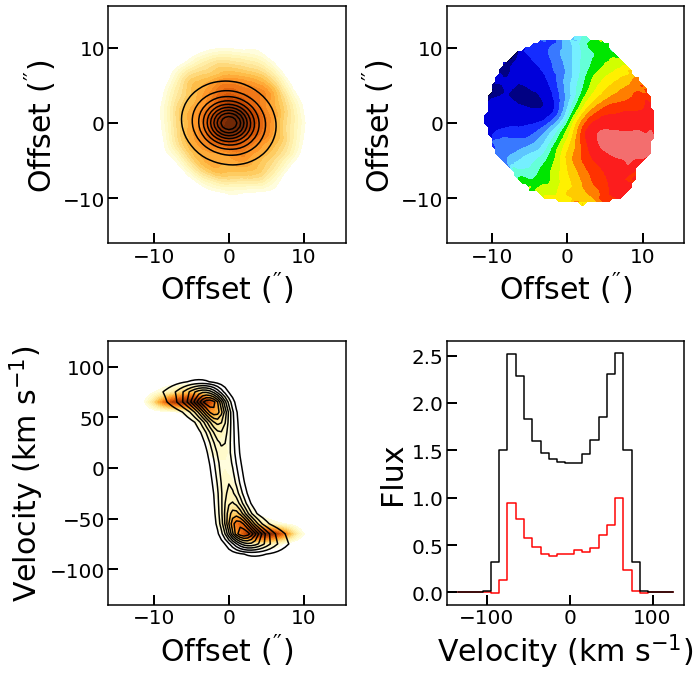

============== Begin simple fitting process ==============
Steps: 0 chi2: 44958.76020706407
Steps: 50 chi2: 44478.78535075915
Steps: 100 chi2: 44440.44936179145
Steps: 150 chi2: 1689.4796201852416
Steps: 200 chi2: 1273.5041578455186
Steps: 250 chi2: 1003.5622795626116
Steps: 300 chi2: 2272.8714394306644
Steps: 350 chi2: 929.1932090989604
Steps: 400 chi2: 782.8613711080313
Steps: 450 chi2: 746.024926626307
Steps: 500 chi2: 745.0573465689739
Steps: 550 chi2: 744.0635234943933
Steps: 600 chi2: 733.6312528144762
Optimization terminated successfully.
         Current function value: 728.365165
         Iterations: 3
         Function evaluations: 631
Simple fitting process took 238.05 seconds
Best fitting parameters:
   PA: 244.26315433915374
   Xc: 54.23800631828906
   Yc: -35.50664262231281
   Vsys: 1280.677402014266
   inc: 30.08084899278454
   totflux: 89.6658112890947
   veldisp: 3.779808308976144
   Rscale_exp: 3.606189401602339
   Vmax: 139.53557616021803
   Rturn: 0.1603043997159478

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 27.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 27.8min finished


Final best fit values and 1sigma errors:
  PA: 244.26786572291414 ± 0.22266782426414977
  Xc: 0.44211696918665866 ± 0.026683289809837057
  Yc: 0.39591159805536774 ± 0.024200594308727952
  Vsys: 1280.6237054985008 + 0.12500493033485327 - 0.1120962430502459
  inc: 29.090856306731624 + 0.25421576816181357 - 0.43688482289698527
  totflux: 91.74370711539342 ± 0.8978583752523335
  veldisp: 4.030167364457066 + 0.11553390272980746 - 0.13848516314484227
  Rscale_exp: 3.7151207343571437 + 0.03057604257580726 - 0.03774909018614325
  Vmax: 143.18798969287582 ± 1.6443767023130391
  Rturn: 0.12093832773785418 + 0.02023460517131731 - 0.017475958618534432
MCMC fitting process took 2455.33 seconds


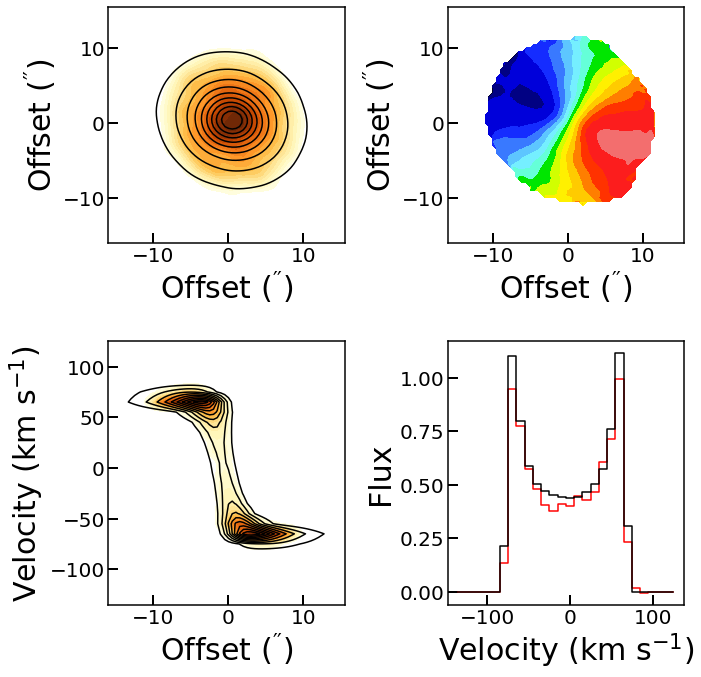

In [28]:
fit.niters=10000
bestvals, besterrs, outputvalue, outputll,_ = fit.run(method='both')

In [29]:
print(Table([fit.labels,bestvals,besterrs],names=('Quantity', 'Bestfit','1-sigma error')))

 Quantity        Bestfit           1-sigma error     
---------- ------------------- ----------------------
        PA  244.26786572291414     0.2413267722913033
        Xc   54.23800811791888 7.4515562341667674e-06
        Yc  -35.50663997705411  7.246508938284393e-06
      Vsys  1280.6237054985008    0.11673608355686443
       inc  29.090856306731624    0.38764582380682167
   totflux   91.74370711539342     0.9606613403338367
   veldisp   4.030167364457066    0.12264364004162294
Rscale_exp  3.7151207343571437    0.03715130538870558
      Vmax  143.18798969287582     1.6818878346609856
     Rturn 0.12093832773785418   0.017226017107904237


This final model is pretty darn good! Hopefully this gives you a good idea of how to use the flexible rotation curve/surface brightness profile functions!
